In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pclib.nn.models import SmallLinearClassifier
from pclib.optim.train import train
from customdataset import PreloadedDataset
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\joeag\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
# ])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.0
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/60000 [00:00<?, ?it/s]

In [4]:
seed = 42
torch.manual_seed(seed)
model_name = "mnist_pclinear"
model = SmallLinearClassifier(INPUT_SHAPE, NUM_CLASSES, [256], bias=True, symmetric=False).to(device)
step = 0
stats = None

In [5]:
# Train Loop
LEARNING_RATE = 0.000034
NUM_EPOCHS = 30
BATCH_SIZE = 256
REG_COEFF = 1.0
track_td = False
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
)
fig, axs = plt.subplots(3 if track_td else 2, 2, figsize=(12 if track_td else 8, 8))
for i in range(len(model.layers)):
    axs.flat[0].plot(stats['R_mags'][i], label=f"Layer {i}")
    axs.flat[1].plot(stats['E_mags'][i], label=f"Layer {i}")
    axs.flat[2].plot(stats['Weight_means'][i], label=f"Layer {i}")
    axs.flat[3].plot(stats['Weight_stds'][i], label=f"Layer {i}")
    if track_td:
        axs.flat[4].plot(stats['WeightTD_means'][i], label=f"Layer {i}")
        axs.flat[5].plot(stats['WeightTD_stds'][i], label=f"Layer {i}")


axs.flat[0].set_title(f"R_mags")
axs.flat[1].set_title(f"E_mags")
axs.flat[2].set_title(f"Weight_means")
axs.flat[3].set_title(f"Weight_stds")
axs.flat[0].legend()
axs.flat[1].legend()
axs.flat[2].legend()
axs.flat[3].legend()
if track_td:
    axs.flat[4].set_title(f"WeightTD_means")
    axs.flat[5].set_title(f"WeightTD_stds")
    axs.flat[4].legend()
    axs.flat[5].legend()
plt.show()

  0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: 

Max accuracy: 0.7846333333333333


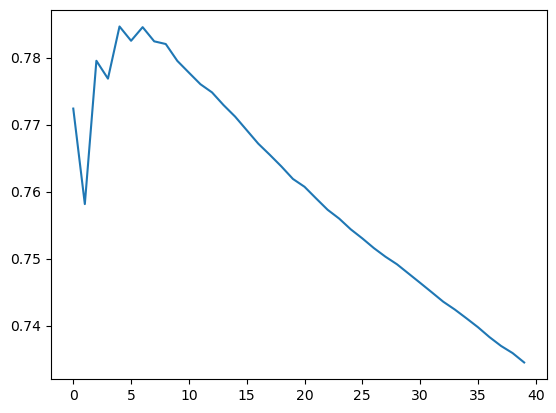

In [6]:
dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=False)
t_steps = 40
correct = [0 for _ in range(t_steps)]
batch_size = 128
for x, y in dataloader:
    # print(f"\nData {idx}: {y}")
    bs = x.shape[0]
    x = x.flatten(start_dim=1).to(device)
    state = model.init_state(x.shape[0])

    for step_i in range(t_steps):
        with torch.no_grad():
            state = model.step(x, state)
        
        pred = state[-1][0].argmax(dim=1)
        correct[step_i] += (pred == y).sum().item()

acc = [c/len(dataset) for c in correct]
# print(acc)
plt.plot(acc)
print(f"Max accuracy: {max(acc)}")